# Find similar patients who are treated differently within the same hospital

## Aims

- Investigate the number of misclassifications within a hospital
- Define a similarity measure using the decision tree structure of a random forest classifier
- For patients with a predicted outcome different to their true outcome, find similar patients that were treated differently

## Code 

### Import libraries 

In [1]:
import os
import json
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

### Load pre-trained hospital models into dictionary `hospital2model` 

keys = hospitals

values = trained_classifier, threshold, patients, outcomes

Note: patients is a numpy array. 

In [2]:
with open ('./models/trained_hospital_models_for _cohort.pkl', 'rb') as f:
    
    hospital2model = pkl.load(f)

### Select a hospital for investigation 

In [3]:
hospital = list(hospital2model.keys())[1]
hospital

'TPFFP4410O'

### Load test cohort and extract hospital patients 

In [4]:
cohort = pd.read_csv('../data/10k_training_test/cohort_10000_test.csv')

test_patients_df = cohort.loc[cohort['StrokeTeam']==hospital]

In [5]:
test_patients_df.head(5)

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,...,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis
105,TPFFP4410O,72.5,68.0,2,2,2.0,2.0,0.0,2.0,2.0,...,0,1,0,1,0,0,0,0,1,0
720,TPFFP4410O,87.5,108.0,0,3,2.0,2.0,2.0,3.0,3.0,...,0,1,0,1,0,0,0,0,1,0
759,TPFFP4410O,82.5,131.0,4,1,2.0,2.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,1,0
779,TPFFP4410O,57.5,145.0,0,0,0.0,0.0,0.0,0.0,2.0,...,0,1,1,0,0,0,0,0,1,1
898,TPFFP4410O,67.5,162.0,1,0,0.0,0.0,1.0,2.0,3.0,...,0,0,1,0,0,0,0,0,1,1


## Misclassifications

If a patient is misclassified by the hospital model for the hospital that they attended, this suggests there is a patient in the data set used to train the model that is similar yet was treated differently

### Find misclassified patients in test cohort

In [6]:
forest, threshold, _, _ = hospital2model[hospital]

In [7]:
y_test = test_patients_df['S2Thrombolysis'].values
X_test = test_patients_df.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1).values

y_prob = forest.predict_proba(X_test)[:,1]
y_pred = np.array([1 if p >= threshold else 0 for p in y_prob])

In [8]:
misclassified = np.where(y_pred!=y_test)[0]
misclassified

array([ 8, 16, 17, 20, 21, 22, 33, 39])

### Posterior probability distribution

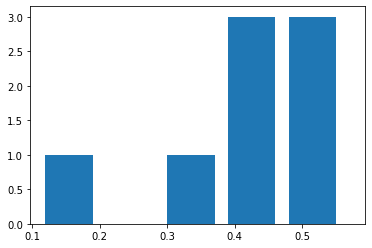

In [9]:
probs = y_prob[misclassified]

plt.hist(probs, 5, width=0.07)

plt.show()

## Similarity Metric 

When a decision tree is fit to the training data, each internal node in the tree will be split into two further nodes based on the feature that maximises the information gain (or minimises the entropy). Once a split results in two nodes that are pure (only containing samples from a single class) no further information gain is possible: the two nodes are leaves, representing the ends of two paths through the tree. As each patient can take only one path through the decision tree, and all patients start in the same node (the root node), we can use these paths to find the similarity between any pair of patients:


$S(i,j) = \frac{P(i,j)}{\sqrt{P(i)P(j)}}$.


Here, $S(i,j)$ represents the similarity between patient $i$ and patient $j$ as a function of each patient's path, $P$, through the decision tree, where $P(i)$ correspond to the path length of patient $i$, $P(j)$ the path length of $j$ and $P(i,j)$ the length of the shared path of $i$ and $j$. 

Path length is measured using the information gain (change in entropy) at each split. Consider patient $z$, who takes a path through the decision tree which is comprised of a set of $N$ nodes, each passed sequentially and with index $n \in [1,N]$, where $n=1$ represents the root node and $n=N$ the leaf node. If each node with index $n$ has $X_n$ patients passing through it, the length of the path of patient $z$, $P(z)$, is given by:


$P(z)= \sum_{n=1}^{N-1} X_{n+1} (H_n - H_{n+1} \frac{X_{n+1}}{X_n})$, 


where $H_n$ is the entropy at node $n$ and the information gain at each split has been weighted by $X_{n+1}$, the total number of patients that move from node $n$ to node $n+1$.

From the second equation it is clear that if patients $i$ and $j$ take exactly the same path through the decision tree their path lengths are equal: $P(i) = P(j) = P(i,j)$. Substituting this into the first equation it is clear that if two patients take identical paths the similarity between them is one. Conversely, if patients $i$ and $j$ diverge at the root node ($n=1$), their shared path contains only this node: $P(i,j) = 0$ and hence the similarity between them is equal to zero.

As a random forest is composed of many decision trees, for each pair of patients we take the distance between them as the average over all trees in the forest. Using this measure of similarity, for each patient in each hospital we found the most similar patients that are treated differently.

### Functions 

####  Node weights

In [10]:
def find_information_gain(X_train, y_train, estimator):
    
    """
    Function to find the information gain for each branch in a tree
    
    Input
    
    X_train: (numpy array) features used to train the DecisionTree classifier
    y_train: (numpy array) target used to train the DecisionTree classifier
    estimator: (sklearn model) trained DecisionTree classifier
    
    Output
    
    info_gain: (numpy array) information gain associated with move to child 
                             node (node i) from parent node.
    """
    
    
    # claculate the entropy of each node
    
    y_true = np.where(y_train==1)
    y_false = np.where(y_train==0)
    
    X_true = X_train[y_true]
    X_false = X_train[y_false]
    
    node_indicator_false = estimator.decision_path(X_false).toarray()
    node_indicator_true = estimator.decision_path(X_true).toarray()
    
    total_passing_true = node_indicator_true.sum(axis=0)
    total_passing_false = node_indicator_false.sum(axis=0)
    
    n_nodes = len(total_passing_true)
    
    entropies = np.zeros(n_nodes)
    
    left_child = estimator.tree_.children_left
    right_child = estimator.tree_.children_right
    
    for i in range(n_nodes):
        
        true = total_passing_true[i]
        false = total_passing_false[i]
        
        if true==0 and false==0:
            
            print('Node Not Passed')
            
            continue
            
        if true==0 or false==0:
            
            entropies[i] = 0
            
        else:
            
            entropies[i] = -(true/(true+false)) * np.log2(true/(true+false)) \
                            - (false/(true+false))*np.log2(false/(true+false))
        

            
    # use the entropy to calculate the information gain for each node
            
    info_gain = np.zeros(n_nodes)
    
    
    total_passing = estimator.decision_path(X_train).toarray().sum(axis=0)
    
    for i in range(1,n_nodes):
        

        loc_left = np.where(left_child==i)[0]
        loc_right = np.where(right_child==i)[0]
        
        if len(loc_left==1):
            
            parent = loc_left[0]
            
            
        elif len(loc_right==1):
            
            parent = loc_right[0]
            
        else:
            
            raise Exception("Cant find parent")
            
            
        info_gain[i] = entropies[parent] - \
                        total_passing[i]*entropies[i]/total_passing[parent]

    
        
    return info_gain

In [11]:
def find_node_weight(X_train, y_train, estimator):
    
    """
    Function to find the weight of a node. Weight is defined as the product
    of the number of data points passing the node (flow) and the information
    gain at the node.
    
    Input
    
    X_train: (numpy array) features used to train the DecisionTree classifier
    y_train: (numpy array) target used to train the DecisionTree classifier
    estimator: (sklearn model) trained DecisionTree classifier
    
    Output
    
    weight: (numpy array) weight (flows * info_gain) of each node
    
    """
    
    node_indicator = estimator.decision_path(X_train).toarray()
    
    flows = node_indicator.sum(axis=0)

    info_gain = find_information_gain(X_train, y_train, estimator)
    
    if len(flows) != len(info_gain):
        
        raise Exception("Length mismatch")
        
    return flows*info_gain

In [12]:
def find_forest_weight(X_train, y_train, forest):
    
    trees = forest.estimators_
    
    results = []
    
    for i,estimator in enumerate(trees):
        
        weight = find_node_weight(X_train, y_train, estimator)
        
        results.append(weight)
        
    return np.array(results)

#### Caclulate Similarity 

In [13]:
def find_similar_patients_tree(patient, test_set, estimator, weights):
    
    """
    Function to calculate the similarity between a single patient and all other
    patients in a data set using a single DecisionTree classifier
    
    Input
    
    patient:    index of comparison patient in test_set
    test_set:   sub-set of n data points unseen by estimator. Must include 
                patient
    estimator:  trained sklearn DecisionTreeClassifier
    weights:    array of length n-nodes. 
    
    Output
    
    similarity: (n-dim array) index of patients and similarity
    
    """
    
    similarity = np.zeros(test_set.shape[0])
    
    paths = estimator.decision_path(test_set)
    
    patient_nodes = paths.toarray()[patient]
    
    for n in range(test_set.shape[0]):
        
        sample_ids = [patient, n]
        
        patient_paths = paths.toarray()[sample_ids]
    
        common_nodes = (patient_paths.sum(axis=0) ==
                    len(sample_ids))
        
        common_node_weights = weights[common_nodes]
        
        path_length = sum(common_node_weights)
        
        p0_path_length = sum(patient_paths[0]*weights)
        p1_path_length = sum(patient_paths[1]*weights)
        
        similar = path_length / np.sqrt(p0_path_length*p1_path_length)
        
        similarity[n] = similar
        
    return similarity

In [14]:
def find_similar_patients(patient, test_set, forest, weights):
    
    """
    Function to calculate the similarity between a single patient and all other
    patients in a data set using a RandomForest classifier
    
    Input
    
    patient:    index of comparison patient in test_set
    test_set:   sub-set of n data points unseen by estimator. Must include 
                patient
    forest:     trained sklearn RandomForestClassifier
    weights:    array of length n-nodes. 
    
    Output
    
    results: (n-dim array) similarity between patient and test_set for each tree
                           in the RandomForest classifier  
    """
    
    trees = forest.estimators_
    
    results = np.zeros((len(trees), test_set.shape[0]))
    
    for i,estimator in enumerate(trees):
        
        similarity = find_similar_patients_tree(patient, test_set, estimator, weights[i])
        
        results[i] = similarity
        
    return results

### Example hospital 

In [15]:
forest, threshold, train_patients, train_outcomes = hospital2model[hospital]

In [16]:
weights = find_forest_weight(train_patients, train_outcomes, forest)

In [17]:
weights.shape

(100,)

### Pairwise similarity 

In [18]:
test_patients = test_patients_df.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1).values
test_outcomes = test_patients_df['S2Thrombolysis'].values

In [19]:
similarity = find_similar_patients(0, test_patients, forest, weights)

In [20]:
similarity.shape

(100, 42)

`similarity` contains one row for each decision tree in the random forest classifier. Each row contains the pairwise similarity between `patient` and all other patients. 

Note that the similarity between `patient` and itself (in this case, element `0` of each row) is always equal to 1.

In [21]:
# average similarity across all trees
results = similarity.sum(axis=0)/100

In [22]:
results

array([1.        , 0.41878349, 0.41385524, 0.30315102, 0.28188906,
       0.31645625, 0.44306756, 0.17333223, 0.35602158, 0.46386653,
       0.2490115 , 0.33010815, 0.50437351, 0.12329451, 0.17538473,
       0.19784455, 0.35274581, 0.29956862, 0.29864365, 0.2882998 ,
       0.18215119, 0.39094488, 0.35923549, 0.39327842, 0.41762123,
       0.48577199, 0.11948557, 0.21997094, 0.40880923, 0.50791922,
       0.38785235, 0.30787927, 0.53550742, 0.42006776, 0.23841425,
       0.3628097 , 0.20345056, 0.33015945, 0.16756539, 0.24487966,
       0.16356513, 0.29071159])

## Most similar patients with a different outcome 

### Identify patients with a predicted outcome different to their true outcome

In [23]:
predicted_outcome = forest.predict(test_patients)

patient_index = np.where(predicted_outcome!=test_outcomes)[0]

In [24]:
patient_index

array([ 8, 17, 20, 29, 39])

Show actual outcomes for patients:

In [25]:
actual = [test_outcomes[i] for i in patient_index]

print ('Actual:', actual)

Actual: [0, 1, 1, 1, 1]


### For each patient, find 5 most similar patients with a different outcome in training set 

In [26]:
%%time

most_similar = []

for i in patient_index:
    
    patient = test_patients[i]
    
    outcome = test_outcomes[i]
    
    opposite = np.where(train_outcomes != outcome)[0]
    

    X = np.vstack((patient, train_patients[opposite]))
    y = np.concatenate(([outcome], train_outcomes[opposite]))

    results = find_similar_patients(0, X, forest, weights)
            
    summed_results = results.sum(axis=0)[1:] #remove similarity between patient and itself
            
    five_indices = np.argpartition(summed_results, -5)[-5:]

    similar_patients = train_patients[opposite][five_indices]

    S = summed_results[five_indices]

    most_similar.append([S, summed_results, outcome, i, patient, similar_patients])
        

CPU times: user 7.32 s, sys: 0 ns, total: 7.32 s
Wall time: 7.32 s


### Get feature importances for hospital 

In [27]:
features = cohort.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1).columns.values
importances = forest.feature_importances_

## Example where thrombolysis was not given when expected

In [28]:
patient_of_interest = 0

### Create dataframe for patient

In [29]:
S, _, _, _, patient, similar_patients = most_similar[patient_of_interest]

In [30]:
S_index = np.argsort(S)
S_index

array([0, 1, 3, 4, 2])

In [31]:
patient_df = pd.DataFrame(index = features)
patient_df['Importance'] = importances
patient_df['Patient'] = patient

for i,s in enumerate(S_index):
    
    patient_df[str(i+1)] = similar_patients[s]

### Sort dataframe according to feature importance 

In [32]:
patient_df = patient_df.sort_values(by='Importance', ascending=False)
patient_df.drop(['Importance'], axis=1, inplace=True)
patient_df.to_csv('./output/similar_patients_treated_differently_1.csv')

patient_df

,Patient,1,2,3,4,5
S2BrainImagingTime_min,23.0,19.0,11.0,33.0,30.0,12.0
S2NihssArrival,4.0,5.0,6.0,9.0,6.0,8.0
S1OnsetToArrival_min,83.0,149.0,134.0,121.0,79.0,82.0
S2StrokeType_Primary Intracerebral Haemorrhage,0.0,0.0,0.0,0.0,0.0,0.0
S2RankinBeforeStroke,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
AFAnticoagulentHeparin_Yes,0.0,0.0,0.0,0.0,0.0,0.0
S1OnsetInHospital_Yes,0.0,0.0,0.0,0.0,0.0,0.0
S1OnsetInHospital_No,1.0,1.0,1.0,1.0,1.0,1.0
S1Ethnicity_Mixed,0.0,0.0,0.0,0.0,0.0,0.0


### Rescale 

As some features, such as stroke to arrival time and age, have a much larger range than other features, we rescale them so that all features can be visualised on one axis

In [33]:
def rescale(row, df, time=False, age=False):
    
    vals = df.iloc[row].values
    
    if len(set(vals))==1:
        
        rescaled=vals
        
    if time==True:
        
        rescaled=vals/60
        
    elif age==True:
        
        rescaled=vals/10
    
    else:
        #rescaled = [(v - vals[0]) for v in vals]
        rescaled = vals
    
    return rescaled

In [34]:
rescaled_results = patient_df.copy()

indx_list = rescaled_results.index.tolist()

for i in range(len(rescaled_results)):
    
    indx = rescaled_results.index[i]
    
    if indx in ['S1OnsetToArrival_min']:#, 'S2BrainImagingTime_min']:
        
        rescaled = rescale(i,rescaled_results, time=True)
        indx_list[i] = indx.split('_')[0] + '_hours'
        
    elif indx in ['S1AgeOnArrival']:
        
        rescaled = rescale(i,rescaled_results, age=True)
        indx_list[i] = indx + '_decades'
        
    else:
        rescaled = rescale(i,rescaled_results)
    
    rescaled_results.loc[indx]=rescaled
    
rescaled_results.index = indx_list

### Plot 

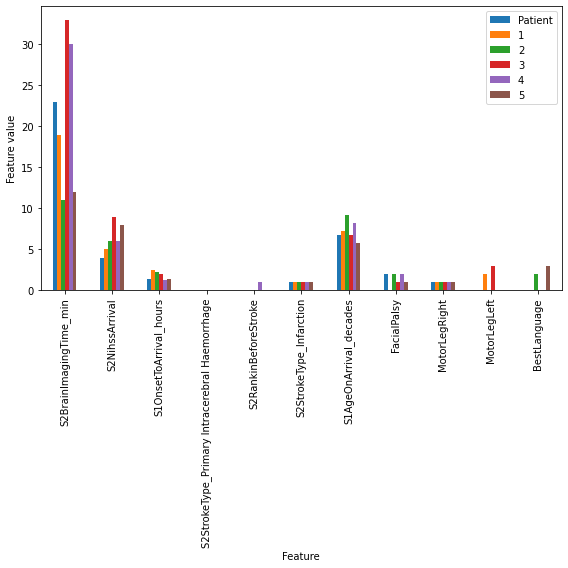

In [35]:
rescaled_results.plot(kind='bar',  stacked=False, alpha=1, figsize=(8,8),
                     xlabel='Feature', ylabel='Feature value')  

plt.xlim(None,10.5)

plt.tight_layout()

plt.savefig('./figures/within_hospital_variability/5_similar_bar_patient_not_treated.jpg', dpi=300)
plt.show()

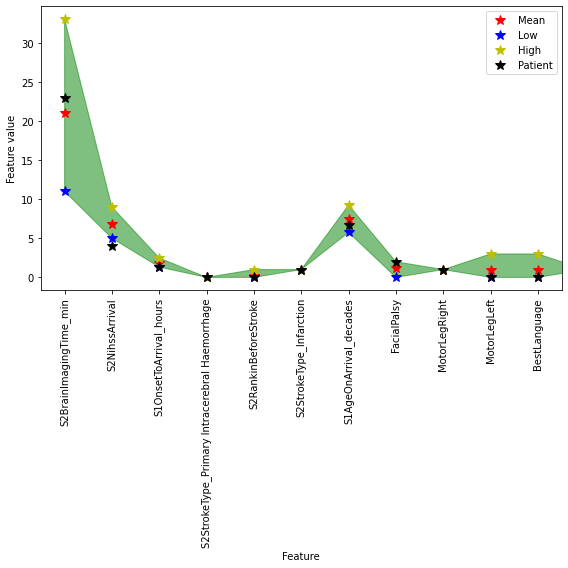

In [36]:
fig,ax = plt.subplots(figsize=(8,8))

xvals = rescaled_results.index.values
pvals = rescaled_results['Patient']
mvals = [np.mean(rescaled_results.loc[feature].values[1:]) for feature in rescaled_results.index]
lvals = [min(rescaled_results.loc[feature].values[1:]) for feature in rescaled_results.index]
hvals = [max(rescaled_results.loc[feature].values[1:]) for feature in rescaled_results.index]

plt.plot(xvals, mvals, 'r*', ms=10, label='Mean')
plt.plot(xvals, lvals, 'b*', ms=10, label='Low')
plt.plot(xvals, hvals, 'y*', ms=10, label='High')
plt.plot(xvals, pvals, 'k*', ms=10, label='Patient')
plt.fill_between(xvals, lvals, hvals, color='g', alpha=0.5)
plt.xlim(-0.5,10.5)
plt.xticks(rotation=90)
plt.legend(loc='best')
ax.set_xlabel('Feature')
ax.set_ylabel('Feature value')
plt.tight_layout()

plt.savefig('./figures/within_hospital_variability/5_similar_range_patient_not_treated.jpg', dpi=300)

plt.show()

## Example where thrombolysis was given when not expected

In [37]:
patient_of_interest = 1

S, _, _, _, patient, similar_patients = most_similar[patient_of_interest]
S_index = np.argsort(S)
S_index

array([0, 1, 2, 3, 4])

In [38]:
patient_df = pd.DataFrame(index = features)
patient_df['Importance'] = importances
patient_df['Patient'] = patient

for i,s in enumerate(S_index):
    patient_df[str(i+1)] = similar_patients[s]
    
patient_df = patient_df.sort_values(by='Importance', ascending=False)
patient_df.drop(['Importance'], axis=1, inplace=True)
patient_df.to_csv('./output/similar_patients_treated_differently_2.csv')

patient_df

,Patient,1,2,3,4,5
S2BrainImagingTime_min,40.0,88.0,40.0,27.0,51.0,35.0
S2NihssArrival,9.0,11.0,10.0,6.0,6.0,6.0
S1OnsetToArrival_min,105.0,67.0,122.0,83.0,75.0,160.0
S2StrokeType_Primary Intracerebral Haemorrhage,0.0,0.0,0.0,0.0,0.0,0.0
S2RankinBeforeStroke,0.0,0.0,4.0,0.0,3.0,0.0
...,...,...,...,...,...,...
AFAnticoagulentHeparin_Yes,0.0,0.0,0.0,0.0,0.0,0.0
S1OnsetInHospital_Yes,0.0,0.0,0.0,0.0,0.0,0.0
S1OnsetInHospital_No,1.0,1.0,1.0,1.0,1.0,1.0
S1Ethnicity_Mixed,0.0,0.0,0.0,0.0,0.0,0.0


Rescale:

In [39]:
rescaled_results = patient_df.copy()

indx_list = rescaled_results.index.tolist()

for i in range(len(rescaled_results)):
    
    indx = rescaled_results.index[i]
    
    if indx in ['S1OnsetToArrival_min']:#, 'S2BrainImagingTime_min']:
        
        rescaled = rescale(i,rescaled_results, time=True)
        indx_list[i] = indx.split('_')[0] + '_hours'
        
    elif indx in ['S1AgeOnArrival']:
        
        rescaled = rescale(i,rescaled_results, age=True)
        indx_list[i] = indx + '_decades'
        
    else:
        rescaled = rescale(i,rescaled_results)
    
    rescaled_results.loc[indx]=rescaled
    
rescaled_results.index = indx_list

Plot

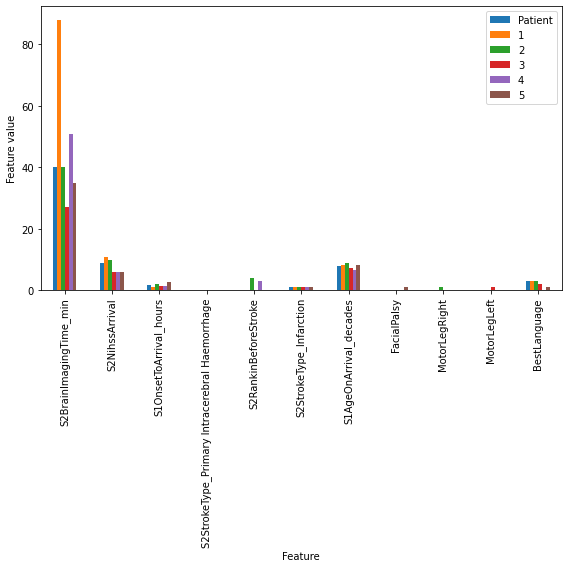

In [40]:
rescaled_results.plot(kind='bar',  stacked=False, alpha=1, figsize=(8,8),
                      xlabel='Feature', ylabel='Feature value')

plt.xlim(None,10.5)

plt.tight_layout()

plt.savefig('./figures/within_hospital_variability/5_similar_bar_patient_treated.jpg', dpi=300)
plt.show()

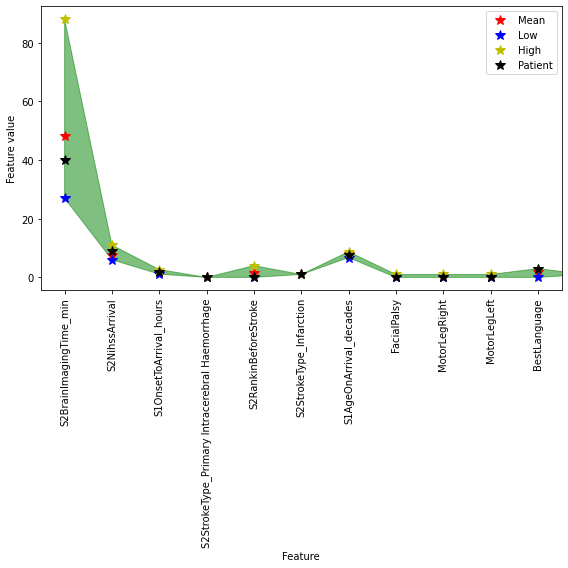

In [41]:
fig,ax = plt.subplots(figsize=(8,8))

xvals = rescaled_results.index.values
pvals = rescaled_results['Patient']
mvals = [np.mean(rescaled_results.loc[feature].values[1:]) for feature in rescaled_results.index]
lvals = [min(rescaled_results.loc[feature].values[1:]) for feature in rescaled_results.index]
hvals = [max(rescaled_results.loc[feature].values[1:]) for feature in rescaled_results.index]

plt.plot(xvals, mvals, 'r*', ms=10, label='Mean')
plt.plot(xvals, lvals, 'b*', ms=10, label='Low')
plt.plot(xvals, hvals, 'y*', ms=10, label='High')
plt.plot(xvals, pvals, 'k*', ms=10, label='Patient')
plt.fill_between(xvals, lvals, hvals, color='g', alpha=0.5)
plt.xlim(-0.5,10.5)
plt.xticks(rotation=90)
plt.legend(loc='best')
ax.set_xlabel('Feature')
ax.set_ylabel('Feature value')

plt.tight_layout()

plt.savefig('./figures/within_hospital_variability/5_similar_range_patient_treated.jpg', dpi=300)

plt.show()

## Observations

- Misclassifications indicate that there is variability in clinical decision making within a hospital
- We can use the structure of the Random Forest classifier to define a similarity metric
- For patients that are incorrectly classified, we can find similar patients that were treated differently, further demonstrating variation in decision making within a hospital